In [1]:
import os
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
from Bio.SeqUtils import seq3, seq1
from collections import Counter
import scipy.stats as scistats
from matplotlib import cm

import difflib
import Levenshtein

sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils
import plot_style_utils

sys.path.append('../A008_analyze_chip_1/')
import A008_common

%reload_ext autoreload
%autoreload 2

In [2]:
GFP_LIB_REGION = [int(29), int(110)] # [inclusive, exclusive] - see A051a mlpe-gfp-pilot
BLAC_LIB_REGION = [132, 213] # [inclusive, exclusive] - see A051a mlpe-gfp-pilot

In [3]:
print(constants.AVGFP_AA_SEQ) ## WT avGFP aa seq

MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK


In [4]:
inf_brightness_data_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 'A052b_Chip_1_inferred_brightness_v2.csv')

data_io_utils.sync_s3_path_to_local(inf_brightness_data_file, is_single_file=True)

df = pd.read_csv(inf_brightness_data_file)

q = df['id'].apply(lambda s: pd.Series(A008_common.split_seq_id_into_features(s)))
df = df.merge(q, left_index=True, right_index=True)

RELEVANT_COLS = ['id', 'qfunc', 'seq', 'model', 'ntrain', 'rep', 'special_case']
df_gfp = df[RELEVANT_COLS]

print(df_gfp.shape)
display(df_gfp.head())

(14306, 7)


,id,qfunc,seq,model,ntrain,rep,special_case
0,GFP_SimAnneal-ET_Global_Init_2-0024-04-36079a2...,2.205245,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGPRDATYGKMTPKF...,ET_Global_Init_2,24.0,4.0,
1,GFP_SimAnneal-OneHot-0024-04-4279eeb-seq_idx_2...,1.945739,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGEGDATYGKLSLKF...,OneHot,24.0,4.0,
2,GFP_SimAnneal-ET_Random_Init_1-0024-04-1989c09...,2.079981,MSKGEELFTGVVPILVELDGDVNGHKFSVKMEGEGNPTGGKLIQKF...,ET_Random_Init_1,24.0,4.0,
3,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.180828,MSKGEELFTGVVPILVELDGDVNGHKFSVKGIGEGDATMGKLTIRF...,ET_Global_Init_1,24.0,4.0,
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.670093,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGEATYGKLTLKF...,ET_Global_Init_1,24.0,4.0,


In [5]:
WT_FUNCTION = df_gfp[df_gfp['id'] == 'avGFP']['qfunc'].iloc[0]

In [6]:
df_gfp['normalized_qfunc'] = df_gfp['qfunc'] - np.min(df_gfp['qfunc'])

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
df_gfp.model.value_counts()

ET_Global_Init_1    3824
OneHot              3822
ET_Global_Init_2    3000
ET_Random_Init_1    2997
Name: model, dtype: int64

In [8]:
df_gfp = df_gfp[(df_gfp['model'].values == "ET_Global_Init_2") | (df_gfp['model'].values == "ET_Global_Init_1")]
df_gfp

,id,qfunc,seq,model,ntrain,rep,special_case,normalized_qfunc
0,GFP_SimAnneal-ET_Global_Init_2-0024-04-36079a2...,2.205245,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGPRDATYGKMTPKF...,ET_Global_Init_2,24.0,4.0,,0.274724
3,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.180828,MSKGEELFTGVVPILVELDGDVNGHKFSVKGIGEGDATMGKLTIRF...,ET_Global_Init_1,24.0,4.0,,0.250307
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.670093,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGEATYGKLTLKF...,ET_Global_Init_1,24.0,4.0,,0.739572
5,GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e...,2.643016,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGDATYGKQTLTF...,ET_Global_Init_1,96.0,0.0,,0.712494
6,GFP_SimAnneal-ET_Global_Init_2-0024-03-2a95c17...,1.967877,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGDATYGKLTLKF...,ET_Global_Init_2,24.0,3.0,,0.037356
8,GFP_SimAnneal-ET_Global_Init_1-0096-00-SmallTr...,3.482212,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGTGDATYGKLTLKF...,ET_Global_Init_1,96.0,0.0,SmallTrust,1.551690
9,GFP_SimAnneal-ET_Global_Init_1-0096-02-SmallTr...,3.298095,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGTGDATYGKLTLKF...,ET_Global_Init_1,96.0,2.0,SmallTrust,1.367574
12,GFP_SimAnneal-ET_Global_Init_1-0096-04-30cb4ce...,2.030997,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATVGKLTLKF...,ET_Global_Init_1,96.0,4.0,,0.100476
13,GFP_SimAnneal-ET_Global_Init_2-0096-01-3d7813d...,2.196010,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLTIKF...,ET_Global_Init_2,96.0,1.0,,0.265488
14,GFP_SimAnneal-ET_Global_Init_1-0096-00-SmallTr...,2.721714,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLTLKF...,ET_Global_Init_1,96.0,0.0,SmallTrust,0.791193


In [9]:
df_gfp['region'] = df_gfp['seq'].map(lambda s: s[GFP_LIB_REGION[0]: GFP_LIB_REGION[1]])
df_gfp

,id,qfunc,seq,model,ntrain,rep,special_case,normalized_qfunc,region
0,GFP_SimAnneal-ET_Global_Init_2-0024-04-36079a2...,2.205245,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGPRDATYGKMTPKF...,ET_Global_Init_2,24.0,4.0,,0.274724,KTEGPRDATYGKMTPKFICTTCKLPVPWPTLVTKLSYCVQCFARYP...
3,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.180828,MSKGEELFTGVVPILVELDGDVNGHKFSVKGIGEGDATMGKLTIRF...,ET_Global_Init_1,24.0,4.0,,0.250307,KGIGEGDATMGKLTIRFICTTGWLPVPWPTLLTTLGYGVVCFSRFP...
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.670093,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGEATYGKLTLKF...,ET_Global_Init_1,24.0,4.0,,0.739572,KGQGEGEATYGKLTLKFICTTGKLPVPWPTLVTTLSYGIQCFSRYP...
5,GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e...,2.643016,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGDATYGKQTLTF...,ET_Global_Init_1,96.0,0.0,,0.712494,KGQGEGDATYGKQTLTFICTTGKLPVPWPTLVTTLAYGVQCFSRYP...
6,GFP_SimAnneal-ET_Global_Init_2-0024-03-2a95c17...,1.967877,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGDATYGKLTLKF...,ET_Global_Init_2,24.0,3.0,,0.037356,KGQGEGDATYGKLTLKFICTTGKLPVPWPTLVSTLSYGVQCFSRYP...
8,GFP_SimAnneal-ET_Global_Init_1-0096-00-SmallTr...,3.482212,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGTGDATYGKLTLKF...,ET_Global_Init_1,96.0,0.0,SmallTrust,1.551690,KGEGTGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYP...
9,GFP_SimAnneal-ET_Global_Init_1-0096-02-SmallTr...,3.298095,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGTGDATYGKLTLKF...,ET_Global_Init_1,96.0,2.0,SmallTrust,1.367574,KGEGTGDATYGKLTLKFICTSGKIPVPWPTLVTTLAYGVQCFSRYP...
12,GFP_SimAnneal-ET_Global_Init_1-0096-04-30cb4ce...,2.030997,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATVGKLTLKF...,ET_Global_Init_1,96.0,4.0,,0.100476,KGEGQGDATVGKLTLKFICSTGQLPVPWPTLITTLTYGIACWIRYP...
13,GFP_SimAnneal-ET_Global_Init_2-0096-01-3d7813d...,2.196010,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLTIKF...,ET_Global_Init_2,96.0,1.0,,0.265488,KGEGQGDATYGKLTIKFICTTGKLPVPWPTLVTTLSYGVQCFMRYP...
14,GFP_SimAnneal-ET_Global_Init_1-0096-00-SmallTr...,2.721714,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLTLKF...,ET_Global_Init_1,96.0,0.0,SmallTrust,0.791193,KGEGQGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYP...


In [10]:
df_gfp.special_case.value_counts()

              5999
SmallTrust     825
Name: special_case, dtype: int64

In [11]:
# get rid of the small trust region
df_gfp = df_gfp[df_gfp.special_case != "SmallTrust"]
df_gfp

,id,qfunc,seq,model,ntrain,rep,special_case,normalized_qfunc,region
0,GFP_SimAnneal-ET_Global_Init_2-0024-04-36079a2...,2.205245,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGPRDATYGKMTPKF...,ET_Global_Init_2,24.0,4.0,,0.274724,KTEGPRDATYGKMTPKFICTTCKLPVPWPTLVTKLSYCVQCFARYP...
3,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.180828,MSKGEELFTGVVPILVELDGDVNGHKFSVKGIGEGDATMGKLTIRF...,ET_Global_Init_1,24.0,4.0,,0.250307,KGIGEGDATMGKLTIRFICTTGWLPVPWPTLLTTLGYGVVCFSRFP...
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.670093,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGEATYGKLTLKF...,ET_Global_Init_1,24.0,4.0,,0.739572,KGQGEGEATYGKLTLKFICTTGKLPVPWPTLVTTLSYGIQCFSRYP...
5,GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e...,2.643016,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGDATYGKQTLTF...,ET_Global_Init_1,96.0,0.0,,0.712494,KGQGEGDATYGKQTLTFICTTGKLPVPWPTLVTTLAYGVQCFSRYP...
6,GFP_SimAnneal-ET_Global_Init_2-0024-03-2a95c17...,1.967877,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGDATYGKLTLKF...,ET_Global_Init_2,24.0,3.0,,0.037356,KGQGEGDATYGKLTLKFICTTGKLPVPWPTLVSTLSYGVQCFSRYP...
12,GFP_SimAnneal-ET_Global_Init_1-0096-04-30cb4ce...,2.030997,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATVGKLTLKF...,ET_Global_Init_1,96.0,4.0,,0.100476,KGEGQGDATVGKLTLKFICSTGQLPVPWPTLITTLTYGIACWIRYP...
13,GFP_SimAnneal-ET_Global_Init_2-0096-01-3d7813d...,2.196010,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLTIKF...,ET_Global_Init_2,96.0,1.0,,0.265488,KGEGQGDATYGKLTIKFICTTGKLPVPWPTLVTTLSYGVQCFMRYP...
15,GFP_SimAnneal-ET_Global_Init_2-0024-01-25f01ed...,1.971945,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLTLNF...,ET_Global_Init_2,24.0,1.0,,0.041424,KGEGQGDATYGKLTLNFICTTGRNPVPWPTLVTTLSFGLLCFSRYP...
16,GFP_SimAnneal-ET_Global_Init_2-0024-01-25f01ed...,2.122280,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLEIKF...,ET_Global_Init_2,24.0,1.0,,0.191758,KGEGQGDATYGKLEIKFICTQGKVPVPWPSLVTSLSYGMQCFYRYP...
18,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,3.101698,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGNATAGKLTLKF...,ET_Global_Init_1,24.0,2.0,,1.171176,KGEGEGNATAGKLTLKFICSTGRMPVPWPTLVTTLSYGVQCFSRYP...


In [12]:
gfp_struct = pd.read_csv('gfp_structure_info.csv',index_col=0).set_index('dssp_index', drop=True)
gfp_struct

,aa,ss,rel_ASA,ASA,d_from_active,coord
dssp_index,,,,,,
1,K,-,0.687805,141.0,23.196699,[27.02 8.242 15.493]
2,G,G,0.059524,5.0,19.590591,[26.167 10.97 12.931]
3,E,G,0.247423,48.0,18.625870,[29.631 10.956 11.452]
4,E,G,0.711340,138.0,21.244120,[29.066 7.359 10.277]
5,L,G,0.469512,77.0,19.448942,[26.287 8.517 7.884]
6,F,G,0.020305,4.0,16.997042,[28.984 10.302 5.854]
7,T,S,0.711268,101.0,19.785490,[31.488 7.478 5.112]
8,G,S,0.392857,33.0,19.654554,[30.325 7.175 1.539]
9,V,-,0.528169,75.0,17.719830,[28.861 9.284 -1.231]


In [13]:
# get the region. This index is different and DSSP adds one fake index for the 3 chromophore residues
gfp_struct = gfp_struct.loc[GFP_LIB_REGION[0]-1: GFP_LIB_REGION[1]-4, :]
gfp_struct

,aa,ss,rel_ASA,ASA,d_from_active,coord
dssp_index,,,,,,
28,S,E,0.153846,20.0,14.877874,[16.873 23.858 -6.784]
29,G,E,0.011905,1.0,12.796585,[20.13 21.954 -6.461]
30,E,E,0.680412,132.0,14.184828,[21.13 18.35 -6.827]
31,G,E,0.321429,27.0,13.696326,[24.472 16.586 -6.437]
32,E,E,0.536082,104.0,13.713300,[26.543 14.519 -4.098]
33,G,E,0.011905,1.0,12.280273,[28.92 14.826 -1.211]
34,D,E,0.239264,39.0,14.468298,[31.764 12.703 0.034]
35,A,G,0.056604,6.0,13.537206,[32.87 13.986 3.42 ]
36,T,G,0.415493,59.0,16.919844,[35.71 11.444 3.5 ]


In [14]:
gfp_struct.iloc[35:68,:]

,aa,ss,rel_ASA,ASA,d_from_active,coord
dssp_index,,,,,,
64,V,-,0.133803,19.0,6.123648,[25.95 21.793 3.819]
65,Q,G,0.126263,25.0,6.438129,[29.01 22.067 6.038]
66,C,G,0.000000,0.0,9.982318,[28.44 18.488 7.21 ]
67,F,G,0.025381,5.0,9.662075,[30.416 17.56 4.072]
68,S,S,0.023077,3.0,9.839358,[33.606 19.09 5.464]
69,R,B,0.387097,96.0,13.433380,[36.503 16.766 6.205]
70,Y,-,0.004505,1.0,15.590028,[37.627 16.853 9.8 ]
71,P,-,0.132353,18.0,18.892004,[41.103 15.254 10.161]
72,D,G,0.877301,143.0,22.073301,[41.483 12.368 12.533]


In [15]:
syg = pd.DataFrame({
    'aa': ['S','Y','G'],
    'ss': ['X','X','X'],
    'rel_ASA':[0,0,0],
    'ASA':[0,0,0],
    'coord':np.array([28.781826 , 26.768589 ,  1.6456766]),
    'd_from_active':0
})
syg

,aa,ss,rel_ASA,ASA,coord,d_from_active
0,S,X,0,0,28.781826,0
1,Y,X,0,0,26.768589,0
2,G,X,0,0,1.645677,0


In [16]:
gfp_struct = pd.concat(
    [gfp_struct.iloc[:35,:].reset_index(drop=True), syg, gfp_struct.iloc[35:,:].reset_index(drop=True)]

).reset_index(drop=True)

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [17]:
gfp_struct.iloc[30:40,:]

,ASA,aa,coord,d_from_active,rel_ASA,ss
30,0.0,L,[24.399 32.48 -3.129],8.638686,0.000000,G
31,6.0,V,[27.235 29.969 -2.8 ],5.692042,0.042254,T
32,28.0,T,[27.489 30.07 0.977],3.608024,0.197183,T
33,4.0,T,[23.729 29.902 1.428],5.949512,0.028169,T
34,7.0,L,[23.215 26.996 -0.937],6.140967,0.042683,-
35,0.0,S,28.7818,0.000000,0.000000,X
36,0.0,Y,26.7686,0.000000,0.000000,X
37,0.0,G,1.64568,0.000000,0.000000,X
38,19.0,V,[25.95 21.793 3.819],6.123648,0.133803,-
39,25.0,Q,[29.01 22.067 6.038],6.438129,0.126263,G


In [18]:
len(gfp_struct)

81

In [19]:
df_gfp.region[df_gfp.region.map(lambda s: True if s[:2] == "SG" else False)]

1007     SGKGQGDATYGKLTLKFLCTTGKMPVPWPTLVTTLGYGVQCFSRYP...
1010     SGKGEGSATYGKLTLKFICTTGKLPVPWPTLVTTLAYGIQCFSRYP...
1016     SGKGEGDITYGKVTLKFICTTGKLPVPWPTLVSTLTWGVQCFSRYP...
1018     SGKGEGDMSYGKLTLKFICTTGKLPVPWPTLVTTLAYGVACFSRYP...
1019     SGKGEGDATSGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYP...
1022     SGKGEGDATYGKMSLKFVCTTGKLPVPWPTLVTTLSYGVQCFSRYP...
1023     SGKGEGDATYGKITLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYP...
1025     SGKGEGDATYGKLNLKFICTTGKLPVPWPTLVTTLSYGVQCFMRYP...
1026     SGKGEGDATYGKLTLKFICTTGKMPIPWPTLVTTLSYGVQCFSRYP...
1027     SGKGEGDATYGKLTLKFICTTGKMPVPWPTLVTTLEYGISCFSRYP...
1028     SGKGEGDATYGKLTLKFICTTGKLPVPWPTLVTTISYGVQCFSRYP...
1029     SGKGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYP...
1031     SGKGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYP...
1032     SGKGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLMYGVQCFSNYP...
1033     SGKGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLAYGMTCFTRYP...
1035     SGKGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYP...
1039     SGKGEGDATYGKLTLKFICTTGRLPVPWPTLITTLQYGVQCFSRYP.

In [20]:
num_positions = GFP_LIB_REGION[1] - GFP_LIB_REGION[0]
WT_REGION = constants.AVGFP_AA_SEQ[GFP_LIB_REGION[0]:GFP_LIB_REGION[1]]
WT_REGION

'SGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRA'

In [21]:
# This looks right to me. Now compute the mutation frequency per position


# for each position, make a dictionary of counts of the mutations
num_mutants = [0 for _ in range(num_positions)]
counters = [Counter() for _ in range(num_positions)]

for seq in df_gfp.region:
    for position, aa in enumerate(seq):
        counters[position].update([aa])
        if WT_REGION[position] != aa:
            num_mutants[position] += 1
            
print(len(counters))
print(counters[0])

81
Counter({'S': 5526, 'T': 110, 'Q': 103, 'K': 77, 'R': 33, 'A': 31, 'E': 25, 'N': 15, 'G': 11, 'F': 11, 'P': 8, 'I': 7, 'W': 7, 'H': 6, 'D': 6, 'Y': 6, 'V': 5, 'L': 5, 'M': 4, 'C': 3})


In [22]:
with open("all_ET_mutation_counts.pkl", 'wb') as f:
    pickle.dump(counters,f)

In [23]:
# now do a subset for just the bright ones

df_bright = df_gfp[df_gfp['qfunc'] >= WT_FUNCTION]
num_bright_mutants = [0 for _ in range(num_positions)]
# for each position, make a dictionary of counts of the mutations
bright_counters = [Counter() for _ in range(num_positions)]

for seq in df_bright.region:
    for position, aa in enumerate(seq):
        bright_counters[position].update([aa])
        if WT_REGION[position] != aa:
            num_bright_mutants[position] += 1
print(len(bright_counters))
print(bright_counters[0])

81
Counter({'S': 569, 'K': 14, 'Q': 13, 'T': 12, 'R': 2, 'I': 1, 'M': 1, 'H': 1})


In [24]:
with open("bright_ET_mutation_counts.pkl", 'wb') as f:
    pickle.dump(bright_counters,f)

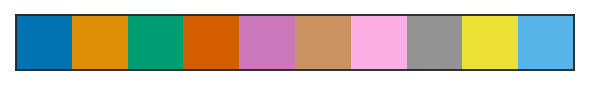

In [25]:
plot_style_utils.set_pub_plot_context()
palette = plot_style_utils.CAT_PALETTE
sns.palplot(plot_style_utils.CAT_PALETTE)

## What to analyze
1. Mutation frequency in buried vs exposed regions
2. Mutation frequency in helices, sheets, and loops
3. Pairs of Cysteine-cysteine bonds

In [26]:
# Followin https://academic.oup.com/nar/article/33/10/3193/1009111, we classify buried residues as those with
# Relative Solvent Accessibility < .2
gfp_struct['buried'] = gfp_struct['rel_ASA'] <= .2
gfp_struct

,ASA,aa,coord,d_from_active,rel_ASA,ss,buried
0,20.0,S,[16.873 23.858 -6.784],14.877874,0.153846,E,True
1,1.0,G,[20.13 21.954 -6.461],12.796585,0.011905,E,True
2,132.0,E,[21.13 18.35 -6.827],14.184828,0.680412,E,False
3,27.0,G,[24.472 16.586 -6.437],13.696326,0.321429,E,False
4,104.0,E,[26.543 14.519 -4.098],13.713300,0.536082,E,False
5,1.0,G,[28.92 14.826 -1.211],12.280273,0.011905,E,True
6,39.0,D,[31.764 12.703 0.034],14.468298,0.239264,E,False
7,6.0,A,[32.87 13.986 3.42 ],13.537206,0.056604,G,True
8,59.0,T,[35.71 11.444 3.5 ],16.919844,0.415493,G,False
9,151.0,Y,[37.386 13.791 0.948],15.586417,0.680180,G,False


In [27]:
# First compute the random solvent vs exposed
# That's just (in expectation) the frequency of buried = True

expectation_buried = gfp_struct.buried.sum() / len(gfp_struct)
expectation_exposed = (len(gfp_struct) - gfp_struct.buried.sum()) / len(gfp_struct)
print(expectation_buried)
print(expectation_exposed)

0.654320987654321
0.345679012345679


In [28]:
# now for all ET
num_mutants

[473,
 145,
 592,
 96,
 523,
 98,
 168,
 159,
 415,
 892,
 55,
 565,
 611,
 964,
 443,
 452,
 117,
 534,
 3,
 439,
 759,
 292,
 634,
 576,
 37,
 620,
 61,
 40,
 60,
 208,
 540,
 776,
 417,
 406,
 919,
 1660,
 853,
 72,
 1061,
 1346,
 42,
 351,
 983,
 566,
 245,
 119,
 553,
 540,
 1558,
 825,
 1813,
 592,
 242,
 536,
 679,
 449,
 539,
 377,
 907,
 47,
 115,
 48,
 449,
 797,
 667,
 483,
 406,
 1089,
 1309,
 1762,
 229,
 1506,
 128,
 288,
 70,
 805,
 461,
 762,
 464,
 283,
 174]

In [29]:
len(df_gfp)

5999

In [30]:
len(df_bright)

613

In [31]:
num_bright_mutants

[44,
 0,
 38,
 0,
 42,
 0,
 16,
 9,
 31,
 68,
 0,
 26,
 39,
 92,
 42,
 17,
 2,
 39,
 0,
 10,
 42,
 0,
 44,
 27,
 0,
 16,
 0,
 0,
 0,
 10,
 6,
 11,
 10,
 7,
 12,
 164,
 1,
 0,
 35,
 54,
 0,
 1,
 62,
 26,
 0,
 0,
 15,
 16,
 49,
 34,
 117,
 5,
 0,
 13,
 21,
 0,
 22,
 12,
 4,
 0,
 7,
 0,
 1,
 51,
 0,
 31,
 0,
 84,
 26,
 168,
 9,
 116,
 7,
 1,
 0,
 82,
 38,
 63,
 8,
 12,
 3]

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


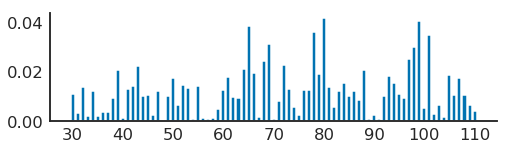

In [32]:
num_mutants = np.array(num_mutants)
fig, ax = plot_style_utils.simple_ax(figsize=(8,2))
ax.bar(np.arange(GFP_LIB_REGION[0], GFP_LIB_REGION[1])+1,num_mutants / np.sum(num_mutants), color=palette[0]  )
plot_style_utils.save_for_pub(fig,'./gfp_ET_linear_mutation_freq.pdf')

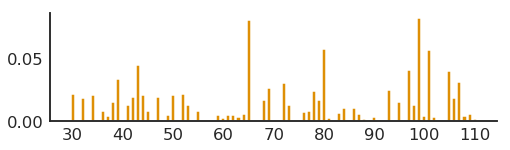

In [33]:
num_bright_mutants = np.array(num_bright_mutants)
fig, ax = plot_style_utils.simple_ax(figsize=(8,2))
ax.bar(np.arange(GFP_LIB_REGION[0], GFP_LIB_REGION[1])+1,num_bright_mutants / np.sum(num_bright_mutants), color=palette[1] )
plot_style_utils.save_for_pub(fig, './gfp_bright_linear_mutation_freq.pdf')

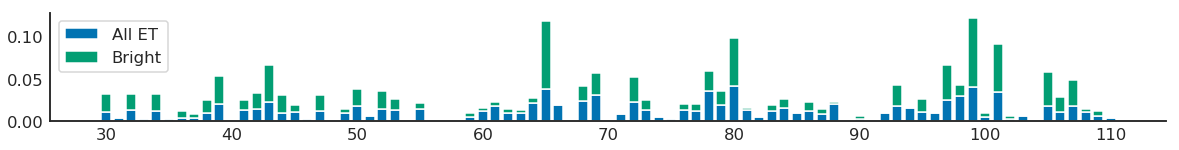

In [34]:
num_mutants = np.array(num_mutants)
fig, ax = plot_style_utils.simple_ax(figsize=(20,2))
ax.bar(np.arange(GFP_LIB_REGION[0], GFP_LIB_REGION[1]) + 1,num_mutants / np.sum(num_mutants), color=palette[0], label="All ET")
ax.bar(np.arange(GFP_LIB_REGION[0], GFP_LIB_REGION[1]) + 1,num_bright_mutants / np.sum(num_bright_mutants), color=palette[2], bottom=num_mutants / np.sum(num_mutants), label="Bright")
ax.legend()
plot_style_utils.save_for_pub(fig,'./gfp_stacked_linear_mutation_freq.pdf')

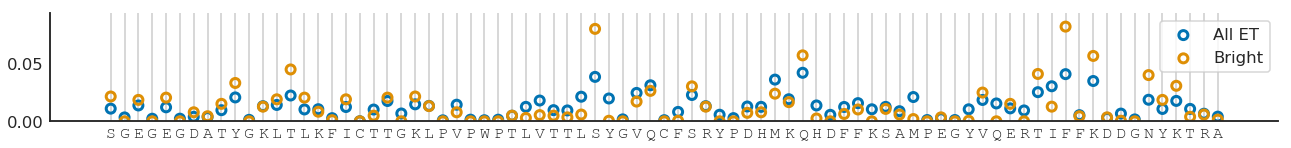

In [35]:
num_mutants = np.array(num_mutants)
max_val = np.max(num_bright_mutants / np.sum(num_bright_mutants))
fig, ax = plot_style_utils.simple_ax(figsize=(22,2))
#ax.bar(np.arange(GFP_LIB_REGION[0], GFP_LIB_REGION[1]) + 1,np.zeros(num_mutants.shape) + max_val, color='black', width=.1, alpha=.2)
ax.scatter(np.arange(GFP_LIB_REGION[0], GFP_LIB_REGION[1]) + 1,num_mutants / np.sum(num_mutants), 
           color=palette[0], label="All ET", marker='o', facecolors='none', linewidth=3)
ax.scatter(np.arange(GFP_LIB_REGION[0], GFP_LIB_REGION[1]) + 1,num_bright_mutants / np.sum(num_bright_mutants), 
           color=palette[1], label="Bright", marker='o', facecolors='none', linewidth=3)
ax.set_ylim(0, None)
ax.xaxis.grid(True)
ax.set_xticks(np.arange(GFP_LIB_REGION[0], GFP_LIB_REGION[1]) + 1)
ax.set_xticklabels(list(WT_REGION), fontname='Courier New')
ax.legend()
plot_style_utils.save_for_pub(fig,'./gfp_scatter_mutation_freq.pdf')

In [36]:
# get the PSSM and compute the effective number of mutations per residue in this window
from proteinnet_parser import _aa_dict
print(_aa_dict)
id_dict = {int(v):k for k,v in _aa_dict.items()}
pssm = pickle.load(open("gfp_2wur_pssm.pkl", 'rb'))
pssm_seq = "".join([id_dict[aa] for aa in pssm['primary']])
pssm = np.array(pssm['evolutionary'])
print(pssm_seq)

{'A': '0', 'C': '1', 'D': '2', 'E': '3', 'F': '4', 'G': '5', 'H': '6', 'I': '7', 'K': '8', 'L': '9', 'M': '10', 'N': '11', 'P': '12', 'Q': '13', 'R': '14', 'S': '15', 'T': '16', 'V': '17', 'W': '18', 'Y': '19'}
MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKTRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYN


In [37]:
"".join(gfp_struct.aa.values)

'SGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRA'

In [38]:
np.argmax(pssm[:,29])

15

In [39]:
region_pssm = pssm[:,29:29+81]
print("".join([id_dict[np.argmax(column)] for column in region_pssm.T] ))

SGEGEGDATYGKLTLKFICTTGKLPFPWPTLVTTFGYGVQCFARYPDHMKQHDFFKSAMPEGYVQERTIFFEDDGNYKTRA


In [40]:
print(pssm_seq[29:29+81])

SGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRA


In [41]:
region_pssm = region_pssm.T

In [42]:
# Avoid log 0
EPSILON = .00000000000001

region_entropy = np.array([-np.sum(p*np.log(p + EPSILON)) for p in region_pssm])
region_entropy

array([1.97055393, 0.23412199, 1.34339882, 0.02249987, 1.48032523,
       0.09216247, 1.36637755, 0.94266055, 1.74840823, 2.02173948,
       0.04516766, 1.68634189, 1.40864631, 1.49508121, 1.70079094,
       1.34346568, 1.63454687, 1.70355944, 1.27083745, 1.09101734,
       1.5064491 , 0.25333805, 1.30800166, 0.36479479, 0.56500493,
       1.00204065, 1.10674127, 1.30498175, 1.61582409, 1.31970708,
       0.54770647, 1.63815319, 1.22410603, 1.79222805, 1.17277466,
       1.99196555, 0.54072311, 0.06968668, 1.90906692, 1.80696438,
       1.64421481, 0.58423104, 1.82741732, 1.58942305, 0.64951327,
       0.30077088, 1.55039307, 1.41307515, 1.3830276 , 0.05475126,
       0.74753443, 1.63316805, 0.80094327, 1.08501831, 0.7902929 ,
       0.75054597, 1.61857437, 1.15743872, 1.29724333, 0.70558506,
       1.13811016, 0.07257851, 0.81254193, 1.6516714 , 1.51655833,
       1.01571702, 0.03450162, 1.37687988, 1.59129042, 2.2496863 ,
       0.50800559, 0.98973959, 0.52485745, 1.03008255, 0.41359

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


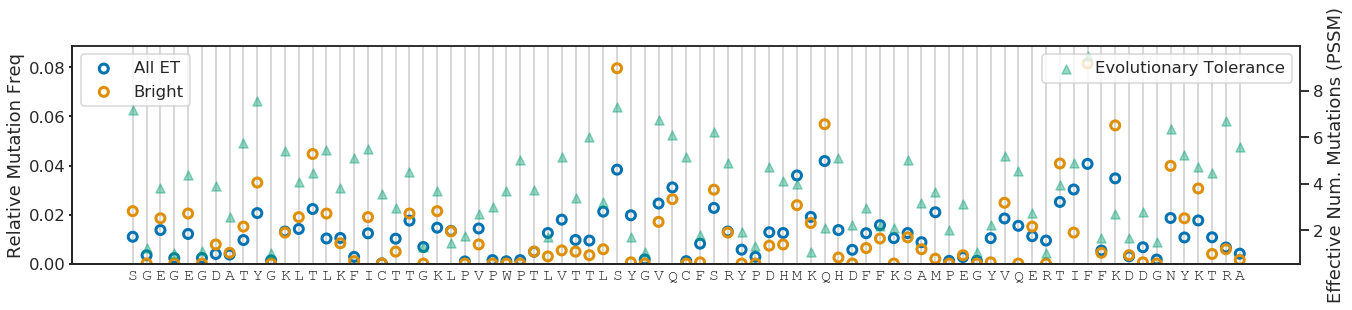

In [43]:
num_mutants = np.array(num_mutants)
max_val = np.max(num_bright_mutants / np.sum(num_bright_mutants))
fig, ax = plot_style_utils.simple_ax(figsize=(22,4))
x = np.arange(GFP_LIB_REGION[0], GFP_LIB_REGION[1]) + 1
#ax.bar(np.arange(GFP_LIB_REGION[0], GFP_LIB_REGION[1]) + 1,np.zeros(num_mutants.shape) + max_val, color='black', width=.1, alpha=.2)
ax.scatter(x,num_mutants / np.sum(num_mutants), 
           color=palette[0], label="All ET", marker='o', facecolors='none', linewidth=3)
ax.scatter(x,num_bright_mutants / np.sum(num_bright_mutants), 
           color=palette[1], label="Bright", marker='o', facecolors='none', linewidth=3)
ax.set_ylim(0, None)


ax.xaxis.grid(True)
ax.set_xticks(x)
ax.set_xticklabels(list(WT_REGION), fontname='Courier New')
ax.set_ylabel('Relative Mutation Freq')
ax2 = ax.twinx()
ax2.scatter(x, np.exp(region_entropy), color=palette[2], marker='^', alpha=.4, label='Evolutionary Tolerance')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('Effective Num. Mutations (PSSM)')#, rotation=-90)

plot_style_utils.save_for_pub(fig,'./gfp_scatter_entropy_mutation_freq.pdf')

avg effective number of mutations is 3.7178505379534155


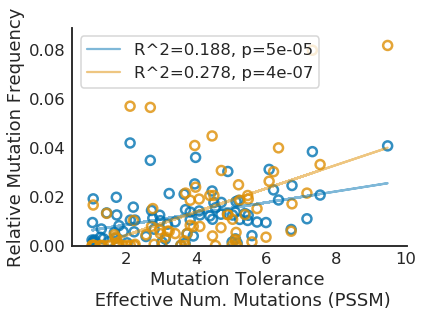

In [44]:
### fig = plt.figure(figsize=(4,4))
#ax = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)
x = np.exp(region_entropy)
print(f'avg effective number of mutations is {np.mean(x)}')
slope, intercept, r_value, p_value, std_err = scistats.linregress(x, num_mutants/ np.sum(num_mutants))
fig, ax = plot_style_utils.simple_ax(figsize=(6,4))
sns.regplot(x, num_mutants/ np.sum(num_mutants), color=palette[0],
            marker='o', ax=ax, scatter_kws={'facecolor':'none', 'linewidth':2.5, 'alpha':.8}, line_kws={'alpha':1},
           fit_reg=False), #facecolors='none', linewidth=
ax.plot(x, intercept + slope*x, color=palette[0], alpha=.5, 
        label=f'R^2={np.around(r_value**2, 3)}, p={np.around(p_value, 5)}')

slope, intercept, r_value, p_value, std_err = scistats.linregress(x, num_bright_mutants/ np.sum(num_bright_mutants))
sns.regplot(x, num_bright_mutants/ np.sum(num_bright_mutants), color=palette[1],
            marker='o', ax=ax, scatter_kws={'facecolor':'none', 'linewidth':2.5, 'alpha':.8}, line_kws={'alpha':1},
           fit_reg=False)#, facecolors='none', linewidth=3)
ax.plot(x, intercept + slope*x, color=palette[1], alpha=.5, 
        label=f'R^2={np.around(r_value**2, 3)}, p={np.around(p_value, 7)}')
ax.set_ylim(0,None)
ax.set_xlabel('Mutation Tolerance \n Effective Num. Mutations (PSSM)')
ax.set_ylabel('Relative Mutation Frequency')
ax.legend()
plot_style_utils.save_for_pub(fig,'./gfp_entropy_vs_mutation_freq.pdf')

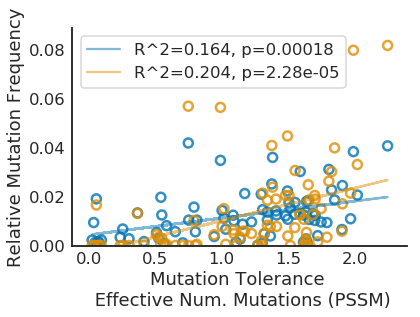

In [45]:
x = region_entropy

slope, intercept, r_value, p_value, std_err = scistats.linregress(x, num_mutants/ np.sum(num_mutants))
fig, ax = plot_style_utils.simple_ax(figsize=(6,4))
sns.regplot(x, num_mutants/ np.sum(num_mutants), color=palette[0],
            marker='o', ax=ax, scatter_kws={'facecolor':'none', 'linewidth':2.5, 'alpha':.8}, line_kws={'alpha':1},
           fit_reg=False), #facecolors='none', linewidth=
ax.plot(x, intercept + slope*x, color=palette[0], alpha=.5, 
        label=f'R^2={np.around(r_value**2, 3)}, p={np.around(p_value, 5)}')

slope, intercept, r_value, p_value, std_err = scistats.linregress(x, num_bright_mutants/ np.sum(num_bright_mutants))
sns.regplot(x, num_bright_mutants/ np.sum(num_bright_mutants), color=palette[1],
            marker='o', ax=ax, scatter_kws={'facecolor':'none', 'linewidth':2.5, 'alpha':.8}, line_kws={'alpha':1},
           fit_reg=False)#, facecolors='none', linewidth=3)
ax.plot(x, intercept + slope*x, color=palette[1], alpha=.5, 
        label=f'R^2={np.around(r_value**2, 3)}, p={np.around(p_value, 7)}')
ax.set_ylim(0,None)
ax.set_xlabel('Mutation Tolerance \n Effective Num. Mutations (PSSM)')
ax.set_ylabel('Relative Mutation Frequency')
ax.legend()

In [46]:
# Treat each buried position in the WT structure as one observation
per_residue_counts = num_mutants[gfp_struct['buried']]

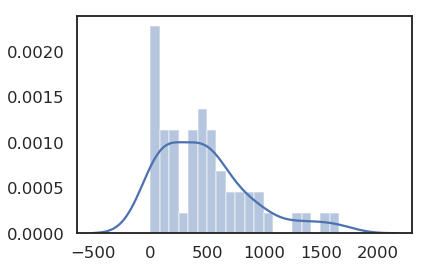

In [47]:
sns.distplot(per_residue_counts, bins=20)

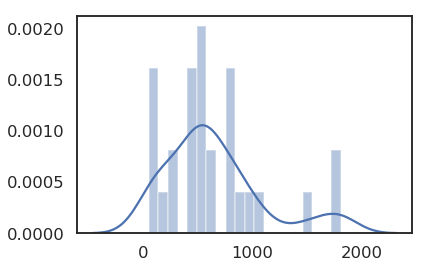

In [48]:
# Look at the exposed
per_residue_counts = num_mutants[~gfp_struct['buried']]
sns.distplot(per_residue_counts, bins=20)

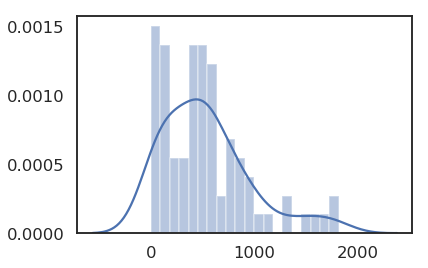

In [49]:
# and the entire histogram
per_residue_counts = num_mutants
sns.distplot(per_residue_counts, bins=20)

In [50]:
all_ET_buried_freq = np.sum(num_mutants[gfp_struct['buried']]) / np.sum(num_mutants)
all_ET_exposed_freq = np.sum(num_mutants[~gfp_struct['buried']]) / np.sum(num_mutants)

In [51]:
all_ET_buried_freq

0.5831006714506565

In [52]:
bright_buried_freq = np.sum(num_bright_mutants[gfp_struct['buried']]) / np.sum(num_bright_mutants)
bright_exposed_freq = np.sum(num_bright_mutants[~gfp_struct['buried']]) / np.sum(num_bright_mutants)
bright_buried_freq

0.41496598639455784

In [53]:
print(f"We expect {expectation_buried} of mutations to be buried, UniRep designs {all_ET_buried_freq}, and after filtering for brighter than WT we have {bright_buried_freq}")

We expect 0.654320987654321 of mutations to be buried, UniRep designs 0.5831006714506565, and after filtering for brighter than WT we have 0.41496598639455784


In [54]:
gfp_struct.ss.value_counts()

E    30
G    16
T    12
-     9
S     6
H     4
X     3
B     1
Name: ss, dtype: int64

In [55]:
gfp_struct[gfp_struct.ss == '-']

,ASA,aa,coord,d_from_active,rel_ASA,ss,buried
23,1.0,L,[ 18.468 34.712 -11.227],18.307884,0.006098,-,True
26,8.0,P,[24.867 37.035 -9.091],15.362332,0.058824,-,True
34,7.0,L,[23.215 26.996 -0.937],6.140967,0.042683,-,True
38,19.0,V,[25.95 21.793 3.819],6.123648,0.133803,-,True
44,1.0,Y,[37.627 16.853 9.8 ],15.590028,0.004505,-,True
45,18.0,P,[41.103 15.254 10.161],18.892004,0.132353,-,True
52,3.0,D,[32.517 18.22 14.054],15.524058,0.018405,-,True
61,0.0,G,[19.918 17.801 11.562],16.041151,0.000000,-,True
74,1.0,G,[22.616 45.233 1.303],19.469704,0.011905,-,True


In [56]:
# Manually classified the residues which were none
parse = {
    'H':'H',
    'G':'H',
    'I':'H',
    'B':'B',
    'E':'B',
    'T':'L',
    'S':'L',
    '-':'L',
    'X':'X',
        
        }
gfp_struct['simple_ss'] = gfp_struct.ss.map(lambda s: parse[s])
gfp_struct

,ASA,aa,coord,d_from_active,rel_ASA,ss,buried,simple_ss
0,20.0,S,[16.873 23.858 -6.784],14.877874,0.153846,E,True,B
1,1.0,G,[20.13 21.954 -6.461],12.796585,0.011905,E,True,B
2,132.0,E,[21.13 18.35 -6.827],14.184828,0.680412,E,False,B
3,27.0,G,[24.472 16.586 -6.437],13.696326,0.321429,E,False,B
4,104.0,E,[26.543 14.519 -4.098],13.713300,0.536082,E,False,B
5,1.0,G,[28.92 14.826 -1.211],12.280273,0.011905,E,True,B
6,39.0,D,[31.764 12.703 0.034],14.468298,0.239264,E,False,B
7,6.0,A,[32.87 13.986 3.42 ],13.537206,0.056604,G,True,H
8,59.0,T,[35.71 11.444 3.5 ],16.919844,0.415493,G,False,H
9,151.0,Y,[37.386 13.791 0.948],15.586417,0.680180,G,False,H


In [57]:
gfp_struct[gfp_struct['aa'] == 'S'] # The chromophore was included as a heteroatom

,ASA,aa,coord,d_from_active,rel_ASA,ss,buried,simple_ss
0,20.0,S,[16.873 23.858 -6.784],14.877874,0.153846,E,True,B
35,0.0,S,28.7818,0.000000,0.000000,X,True,X
42,3.0,S,[33.606 19.09 5.464],9.839358,0.023077,S,True,L
56,19.0,S,[27.04 15.017 15.266],18.073378,0.146154,H,True,H


In [58]:
# Now do secondary structure
expectation = gfp_struct.simple_ss.value_counts() / len(gfp_struct)
expectation

B    0.382716
L    0.333333
H    0.246914
X    0.037037
Name: simple_ss, dtype: float64

In [59]:
# all_mutants
all_mutants = {k: np.sum(num_mutants[gfp_struct.simple_ss == k]) for k in ['B', 'L', 'H', 'X']}
all_mutants

{'B': 16490, 'L': 12127, 'H': 12137, 'X': 2585}

In [60]:
assert sum(all_mutants.values()) == sum(num_mutants)

In [61]:
all_mutants = {k: v/ sum(num_mutants) for k, v in all_mutants.items()}
all_mutants

{'B': 0.38048870532315004,
 'L': 0.27981725466669743,
 'H': 0.28004799372389766,
 'X': 0.059646046286254875}

In [62]:
# now_just the bright ones
bright_mutants = {k: np.sum(num_bright_mutants[gfp_struct.simple_ss == k]) for k in ['B', 'L', 'H', 'X']}
bright_mutants

{'B': 999, 'L': 423, 'H': 471, 'X': 165}

In [63]:
assert sum(bright_mutants.values()) == sum(num_bright_mutants)

In [64]:
bright_mutants = {k: v/ sum(num_bright_mutants) for k, v in bright_mutants.items()}
bright_mutants

{'B': 0.48542274052478135,
 'L': 0.2055393586005831,
 'H': 0.22886297376093295,
 'X': 0.08017492711370262}

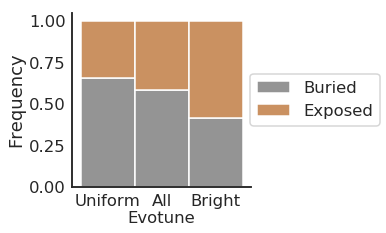

In [65]:
# First do the buried/ exposed 
first_layer = [expectation_buried, all_ET_buried_freq, bright_buried_freq]
second_layer = [expectation_exposed, all_ET_exposed_freq, bright_exposed_freq]
fig, ax = plot_style_utils.simple_ax(figsize=(3.2,3.2))
ax.bar(np.arange(3),first_layer, color=palette[7], label="Buried", width=1)
ax.bar(np.arange(3), second_layer, color=palette[5], bottom=first_layer, label="Exposed", width=1)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Uniform', 'All\nEvotune', 'Bright'])
ax.set_ylabel('Frequency')

ax.legend(loc="center left", bbox_to_anchor=(.95, 0.5))

plot_style_utils.save_for_pub(fig,'./gfp_buried_exposed_bar.pdf')

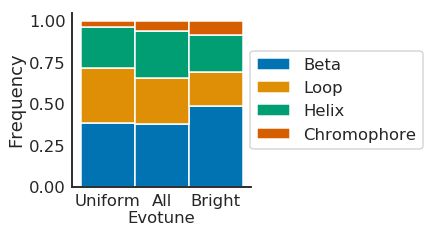

In [66]:
# Now secondary structure
first_layer = np.array([expectation['B'], all_mutants['B'], bright_mutants['B']])
second_layer = np.array([expectation['L'], all_mutants['L'], bright_mutants['L']])
third_layer = np.array([expectation['H'], all_mutants['H'], bright_mutants['H']])
fourth_layer = np.array([expectation['X'], all_mutants['X'], bright_mutants['X']])
fig, ax = plot_style_utils.simple_ax(figsize=(3.2,3.2))
ax.bar(np.arange(3),first_layer, color=palette[0], label="Beta", width=1)
ax.bar(np.arange(3), second_layer, color=palette[1], bottom=first_layer, label="Loop", width=1)
ax.bar(np.arange(3), third_layer, color=palette[2], bottom=first_layer+second_layer, label="Helix", width=1)
ax.bar(np.arange(3), fourth_layer, color=palette[3], bottom=first_layer+second_layer+third_layer, label="Chromophore", width=1)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Uniform', 'All\nEvotune', 'Bright'])
ax.set_ylabel('Frequency')
ax.legend(loc="center left", bbox_to_anchor=(.95, 0.5))

plot_style_utils.save_for_pub(fig,'./gfp_ss.pdf')

In [67]:
df_gfp

,id,qfunc,seq,model,ntrain,rep,special_case,normalized_qfunc,region
0,GFP_SimAnneal-ET_Global_Init_2-0024-04-36079a2...,2.205245,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGPRDATYGKMTPKF...,ET_Global_Init_2,24.0,4.0,,0.274724,KTEGPRDATYGKMTPKFICTTCKLPVPWPTLVTKLSYCVQCFARYP...
3,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.180828,MSKGEELFTGVVPILVELDGDVNGHKFSVKGIGEGDATMGKLTIRF...,ET_Global_Init_1,24.0,4.0,,0.250307,KGIGEGDATMGKLTIRFICTTGWLPVPWPTLLTTLGYGVVCFSRFP...
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.670093,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGEATYGKLTLKF...,ET_Global_Init_1,24.0,4.0,,0.739572,KGQGEGEATYGKLTLKFICTTGKLPVPWPTLVTTLSYGIQCFSRYP...
5,GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e...,2.643016,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGDATYGKQTLTF...,ET_Global_Init_1,96.0,0.0,,0.712494,KGQGEGDATYGKQTLTFICTTGKLPVPWPTLVTTLAYGVQCFSRYP...
6,GFP_SimAnneal-ET_Global_Init_2-0024-03-2a95c17...,1.967877,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGDATYGKLTLKF...,ET_Global_Init_2,24.0,3.0,,0.037356,KGQGEGDATYGKLTLKFICTTGKLPVPWPTLVSTLSYGVQCFSRYP...
12,GFP_SimAnneal-ET_Global_Init_1-0096-04-30cb4ce...,2.030997,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATVGKLTLKF...,ET_Global_Init_1,96.0,4.0,,0.100476,KGEGQGDATVGKLTLKFICSTGQLPVPWPTLITTLTYGIACWIRYP...
13,GFP_SimAnneal-ET_Global_Init_2-0096-01-3d7813d...,2.196010,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLTIKF...,ET_Global_Init_2,96.0,1.0,,0.265488,KGEGQGDATYGKLTIKFICTTGKLPVPWPTLVTTLSYGVQCFMRYP...
15,GFP_SimAnneal-ET_Global_Init_2-0024-01-25f01ed...,1.971945,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLTLNF...,ET_Global_Init_2,24.0,1.0,,0.041424,KGEGQGDATYGKLTLNFICTTGRNPVPWPTLVTTLSFGLLCFSRYP...
16,GFP_SimAnneal-ET_Global_Init_2-0024-01-25f01ed...,2.122280,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLEIKF...,ET_Global_Init_2,24.0,1.0,,0.191758,KGEGQGDATYGKLEIKFICTQGKVPVPWPSLVTSLSYGMQCFYRYP...
18,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,3.101698,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGNATAGKLTLKF...,ET_Global_Init_1,24.0,2.0,,1.171176,KGEGEGNATAGKLTLKFICSTGRMPVPWPTLVTTLSYGVQCFSRYP...


In [68]:
gfp_struct

,ASA,aa,coord,d_from_active,rel_ASA,ss,buried,simple_ss
0,20.0,S,[16.873 23.858 -6.784],14.877874,0.153846,E,True,B
1,1.0,G,[20.13 21.954 -6.461],12.796585,0.011905,E,True,B
2,132.0,E,[21.13 18.35 -6.827],14.184828,0.680412,E,False,B
3,27.0,G,[24.472 16.586 -6.437],13.696326,0.321429,E,False,B
4,104.0,E,[26.543 14.519 -4.098],13.713300,0.536082,E,False,B
5,1.0,G,[28.92 14.826 -1.211],12.280273,0.011905,E,True,B
6,39.0,D,[31.764 12.703 0.034],14.468298,0.239264,E,False,B
7,6.0,A,[32.87 13.986 3.42 ],13.537206,0.056604,G,True,H
8,59.0,T,[35.71 11.444 3.5 ],16.919844,0.415493,G,False,H
9,151.0,Y,[37.386 13.791 0.948],15.586417,0.680180,G,False,H


In [69]:
gfp_struct.index.value_counts()

80    1
39    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
20    1
19    1
18    1
8     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
     ..
70    1
71    1
72    1
73    1
74    1
75    1
76    1
77    1
78    1
61    1
60    1
59    1
49    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
50    1
58    1
51    1
52    1
53    1
54    1
55    1
56    1
57    1
0     1
Length: 81, dtype: int64

In [70]:
def get_distances(seq):
    distances = []
    for i, aa in enumerate(seq):
        if gfp_struct.aa[i] != aa:
            distances.append(gfp_struct.d_from_active[i])
        # else it is not a mutation
    return distances

In [71]:
df_gfp['d_from_active'] = df_gfp.region.map(get_distances)
df_gfp

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,qfunc,seq,model,ntrain,rep,special_case,normalized_qfunc,region,d_from_active
0,GFP_SimAnneal-ET_Global_Init_2-0024-04-36079a2...,2.205245,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGPRDATYGKMTPKF...,ET_Global_Init_2,24.0,4.0,,0.274724,KTEGPRDATYGKMTPKFICTTCKLPVPWPTLVTKLSYCVQCFARYP...,"[14.877874374389648, 12.796585083007812, 13.71..."
3,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.180828,MSKGEELFTGVVPILVELDGDVNGHKFSVKGIGEGDATMGKLTIRF...,ET_Global_Init_1,24.0,4.0,,0.250307,KGIGEGDATMGKLTIRFICTTGWLPVPWPTLLTTLGYGVVCFSRFP...,"[14.877874374389648, 14.18482780456543, 15.586..."
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.670093,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGEATYGKLTLKF...,ET_Global_Init_1,24.0,4.0,,0.739572,KGQGEGEATYGKLTLKFICTTGKLPVPWPTLVTTLSYGIQCFSRYP...,"[14.877874374389648, 14.18482780456543, 14.468..."
5,GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e...,2.643016,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGDATYGKQTLTF...,ET_Global_Init_1,96.0,0.0,,0.712494,KGQGEGDATYGKQTLTFICTTGKLPVPWPTLVTTLAYGVQCFSRYP...,"[14.877874374389648, 14.18482780456543, 10.005..."
6,GFP_SimAnneal-ET_Global_Init_2-0024-03-2a95c17...,1.967877,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGDATYGKLTLKF...,ET_Global_Init_2,24.0,3.0,,0.037356,KGQGEGDATYGKLTLKFICTTGKLPVPWPTLVSTLSYGVQCFSRYP...,"[14.877874374389648, 14.18482780456543, 3.6080..."
12,GFP_SimAnneal-ET_Global_Init_1-0096-04-30cb4ce...,2.030997,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATVGKLTLKF...,ET_Global_Init_1,96.0,4.0,,0.100476,KGEGQGDATVGKLTLKFICSTGQLPVPWPTLITTLTYGIACWIRYP...,"[14.877874374389648, 13.713299751281738, 15.58..."
13,GFP_SimAnneal-ET_Global_Init_2-0096-01-3d7813d...,2.196010,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLTIKF...,ET_Global_Init_2,96.0,1.0,,0.265488,KGEGQGDATYGKLTIKFICTTGKLPVPWPTLVTTLSYGVQCFMRYP...,"[14.877874374389648, 13.713299751281738, 10.93..."
15,GFP_SimAnneal-ET_Global_Init_2-0024-01-25f01ed...,1.971945,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLTLNF...,ET_Global_Init_2,24.0,1.0,,0.041424,KGEGQGDATYGKLTLNFICTTGRNPVPWPTLVTTLSFGLLCFSRYP...,"[14.877874374389648, 13.713299751281738, 13.33..."
16,GFP_SimAnneal-ET_Global_Init_2-0024-01-25f01ed...,2.122280,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLEIKF...,ET_Global_Init_2,24.0,1.0,,0.191758,KGEGQGDATYGKLEIKFICTQGKVPVPWPSLVTSLSYGMQCFYRYP...,"[14.877874374389648, 13.713299751281738, 11.39..."
18,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,3.101698,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGNATAGKLTLKF...,ET_Global_Init_1,24.0,2.0,,1.171176,KGEGEGNATAGKLTLKFICSTGRMPVPWPTLVTTLSYGVQCFSRYP...,"[14.877874374389648, 14.468297958374025, 15.58..."


In [72]:
df_gfp['repeat_qfunc'] = [
    [df_gfp.normalized_qfunc[i]]*len(df_gfp.d_from_active[i]) for i in df_gfp.index.values
]
df_gfp

/media/sandias42/ExDrive/Software/Python/Anaconda/envs/shared_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,qfunc,seq,model,ntrain,rep,special_case,normalized_qfunc,region,d_from_active,repeat_qfunc
0,GFP_SimAnneal-ET_Global_Init_2-0024-04-36079a2...,2.205245,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGPRDATYGKMTPKF...,ET_Global_Init_2,24.0,4.0,,0.274724,KTEGPRDATYGKMTPKFICTTCKLPVPWPTLVTKLSYCVQCFARYP...,"[14.877874374389648, 12.796585083007812, 13.71...","[0.27472381342738106, 0.27472381342738106, 0.2..."
3,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.180828,MSKGEELFTGVVPILVELDGDVNGHKFSVKGIGEGDATMGKLTIRF...,ET_Global_Init_1,24.0,4.0,,0.250307,KGIGEGDATMGKLTIRFICTTGWLPVPWPTLLTTLGYGVVCFSRFP...,"[14.877874374389648, 14.18482780456543, 15.586...","[0.2503069810433496, 0.2503069810433496, 0.250..."
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.670093,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGEATYGKLTLKF...,ET_Global_Init_1,24.0,4.0,,0.739572,KGQGEGEATYGKLTLKFICTTGKLPVPWPTLVTTLSYGIQCFSRYP...,"[14.877874374389648, 14.18482780456543, 14.468...","[0.7395715538797674, 0.7395715538797674, 0.739..."
5,GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e...,2.643016,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGDATYGKQTLTF...,ET_Global_Init_1,96.0,0.0,,0.712494,KGQGEGDATYGKQTLTFICTTGKLPVPWPTLVTTLAYGVQCFSRYP...,"[14.877874374389648, 14.18482780456543, 10.005...","[0.7124941995193514, 0.7124941995193514, 0.712..."
6,GFP_SimAnneal-ET_Global_Init_2-0024-03-2a95c17...,1.967877,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGDATYGKLTLKF...,ET_Global_Init_2,24.0,3.0,,0.037356,KGQGEGDATYGKLTLKFICTTGKLPVPWPTLVSTLSYGVQCFSRYP...,"[14.877874374389648, 14.18482780456543, 3.6080...","[0.03735601573841785, 0.03735601573841785, 0.0..."
12,GFP_SimAnneal-ET_Global_Init_1-0096-04-30cb4ce...,2.030997,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATVGKLTLKF...,ET_Global_Init_1,96.0,4.0,,0.100476,KGEGQGDATVGKLTLKFICSTGQLPVPWPTLITTLTYGIACWIRYP...,"[14.877874374389648, 13.713299751281738, 15.58...","[0.10047604444455671, 0.10047604444455671, 0.1..."
13,GFP_SimAnneal-ET_Global_Init_2-0096-01-3d7813d...,2.196010,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLTIKF...,ET_Global_Init_2,96.0,1.0,,0.265488,KGEGQGDATYGKLTIKFICTTGKLPVPWPTLVTTLSYGVQCFMRYP...,"[14.877874374389648, 13.713299751281738, 10.93...","[0.2654883796134808, 0.2654883796134808, 0.265..."
15,GFP_SimAnneal-ET_Global_Init_2-0024-01-25f01ed...,1.971945,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLTLNF...,ET_Global_Init_2,24.0,1.0,,0.041424,KGEGQGDATYGKLTLNFICTTGRNPVPWPTLVTTLSFGLLCFSRYP...,"[14.877874374389648, 13.713299751281738, 13.33...","[0.04142404567834035, 0.04142404567834035, 0.0..."
16,GFP_SimAnneal-ET_Global_Init_2-0024-01-25f01ed...,2.122280,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGQGDATYGKLEIKF...,ET_Global_Init_2,24.0,1.0,,0.191758,KGEGQGDATYGKLEIKFICTQGKVPVPWPSLVTSLSYGMQCFYRYP...,"[14.877874374389648, 13.713299751281738, 11.39...","[0.19175815506916405, 0.19175815506916405, 0.1..."
18,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,3.101698,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGNATAGKLTLKF...,ET_Global_Init_1,24.0,2.0,,1.171176,KGEGEGNATAGKLTLKFICSTGRMPVPWPTLVTTLSYGVQCFSRYP...,"[14.877874374389648, 14.468297958374025, 15.58...","[1.1711762513204025, 1.1711762513204025, 1.171..."


In [73]:
all_qfunc = np.concatenate(df_gfp.repeat_qfunc.values)
all_d = np.concatenate(df_gfp.d_from_active.values)

In [74]:
all_qfunc

array([0.27472381, 0.27472381, 0.27472381, ..., 0.09304388, 0.09304388,
       0.09304388])

In [75]:
all_d

array([14.87787437, 12.79658508, 13.71329975, ..., 14.77745247,
       12.66761875, 13.59048843])

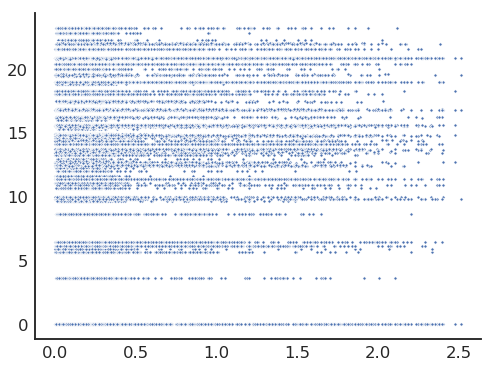

In [76]:
fig, ax = plot_style_utils.simple_ax(figsize=(8,6))

sns.scatterplot(x=all_qfunc, y=all_d,s=10, ax=ax)

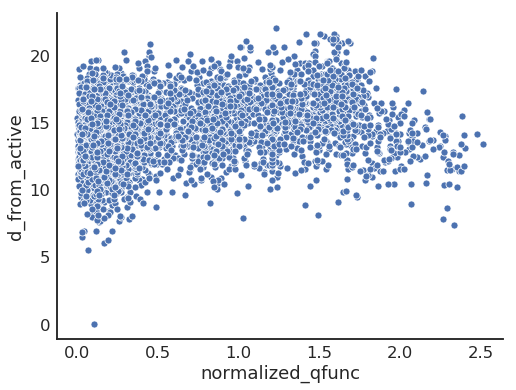

In [77]:
fig, ax = plot_style_utils.simple_ax(figsize=(8,6))

sns.scatterplot(x=df_gfp.normalized_qfunc, y=df_gfp.d_from_active.map(np.mean),s=50, ax=ax)

In [78]:
np.mean(gfp_struct.d_from_active)

14.163784486276132

In [79]:
bright_df_gfp = df_gfp[df_gfp.qfunc >= WT_FUNCTION]
bright_df_gfp

,id,qfunc,seq,model,ntrain,rep,special_case,normalized_qfunc,region,d_from_active,repeat_qfunc
19,GFP_SimAnneal-ET_Global_Init_1-0096-01-2db7371...,3.987025,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGNATYGKMTMKF...,ET_Global_Init_1,96.0,1.0,,2.056503,KGEGEGNATYGKMTMKFICTTGKLPVPWPTLVTTLSYGVQCFSRYP...,"[14.877874374389648, 14.468297958374025, 10.00...","[2.0565034850818122, 2.0565034850818122, 2.056..."
36,GFP_SimAnneal-ET_Global_Init_1-0024-02-31e5414...,3.468903,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATHGKLTLKF...,ET_Global_Init_1,24.0,2.0,,1.538382,KGEGEGDATHGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYP...,"[14.877874374389648, 15.586417198181152, 20.94...","[1.5383817015617007, 1.5383817015617007, 1.538..."
38,GFP_SimAnneal-ET_Global_Init_1-0096-01-2db7371...,3.685966,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATHGAMTLKF...,ET_Global_Init_1,96.0,1.0,,1.755445,KGEGEGDATHGAMTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYP...,"[14.877874374389648, 15.586417198181152, 11.38...","[1.7554449156002094, 1.7554449156002094, 1.755..."
48,GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278...,4.298166,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATYGKLTMKF...,ET_Global_Init_2,24.0,2.0,,2.367645,KGEGEGDATYGKLTMKFVCTTGKLPVPWPTLVTTLTYGVQCFSRYP...,"[14.877874374389648, 10.93511199951172, 16.265...","[2.367644980088251, 2.367644980088251, 2.36764..."
52,GFP_SimAnneal-ET_Global_Init_2-0024-02-f795278...,4.409855,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATYGKLTLKF...,ET_Global_Init_2,24.0,2.0,,2.479334,KGEGEGDATYGKLTLKFICTTGKMPVPWPTLVTTLGYGVQCFSRYP...,"[14.877874374389648, 18.307884216308594, 0.0, ...","[2.479333766778087, 2.479333766778087, 2.47933..."
57,GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e...,4.199682,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATYGKLTLKF...,ET_Global_Init_1,96.0,0.0,,2.269160,KGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYP...,"[14.877874374389648, 0.0, 20.940820693969727, ...","[2.2691604922184467, 2.2691604922184467, 2.269..."
60,GFP_SimAnneal-ET_Global_Init_2-0024-00-17cbc6c...,3.431015,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATYGKLTLKF...,ET_Global_Init_2,24.0,0.0,,1.500493,KGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYP...,"[14.877874374389648, 19.59852409362793, 20.940...","[1.5004933637078601, 1.5004933637078601, 1.500..."
61,GFP_SimAnneal-ET_Global_Init_2-0096-02-1f121a7...,3.469409,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATYGKLTLKF...,ET_Global_Init_2,96.0,2.0,,1.538888,KGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYP...,"[14.877874374389648, 20.419992446899414, 20.94...","[1.5388881372704757, 1.5388881372704757, 1.538..."
68,GFP_SimAnneal-ET_Global_Init_2-0096-01-3d7813d...,3.538051,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATYGKLTLKF...,ET_Global_Init_2,96.0,1.0,,1.607529,KGEGEGDATYGKLTLKFICTTGKLPVPWPSLVTTLSYGVQCFSRYP...,"[14.877874374389648, 10.73488712310791, 20.940...","[1.6075292882299828, 1.6075292882299828, 1.607..."
95,GFP_SimAnneal-ET_Global_Init_2-0096-02-1f121a7...,3.466908,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATYGRLTLKF...,ET_Global_Init_2,96.0,2.0,,1.536386,KGEGEGDATYGRLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYP...,"[14.877874374389648, 11.387840270996096, 20.94...","[1.536386190886436, 1.536386190886436, 1.53638..."


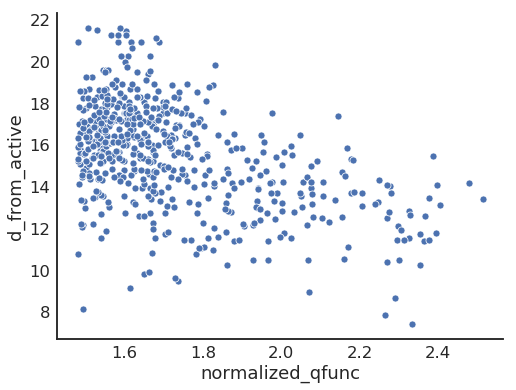

In [80]:
fig, ax = plot_style_utils.simple_ax(figsize=(8,6))

sns.scatterplot(x=bright_df_gfp.normalized_qfunc, y=bright_df_gfp.d_from_active.map(np.mean),s=50, ax=ax)

In [81]:
all_qfunc = np.concatenate(bright_df_gfp.repeat_qfunc.values)
all_d = np.concatenate(bright_df_gfp.d_from_active.values)

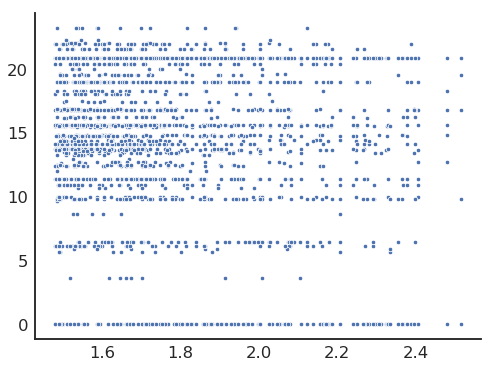

In [82]:
fig, ax = plot_style_utils.simple_ax(figsize=(8,6))

sns.scatterplot(x=all_qfunc, y=all_d,s=20, ax=ax)

<ErrorbarContainer object of 3 artists>

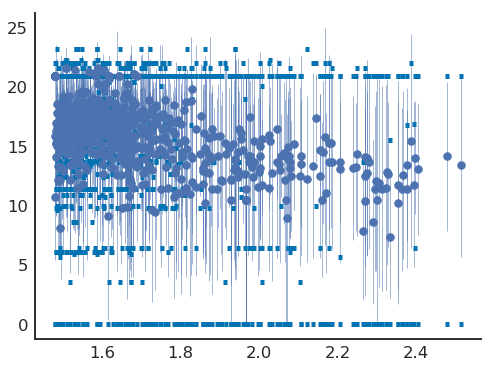

In [83]:
fig, ax = plot_style_utils.simple_ax(figsize=(8,6))

ax.errorbar(bright_df_gfp.normalized_qfunc,
            bright_df_gfp.d_from_active.map(np.mean), 
            bright_df_gfp.d_from_active.map(np.std), 
            linestyle='None',marker='.', linewidth=.5, markersize=15)

maxmin = np.array([bright_df_gfp.d_from_active.map(np.min), bright_df_gfp.d_from_active.map(np.max)])
maxmin = np.abs(maxmin - bright_df_gfp.d_from_active.map(np.mean).values.T)
ax.errorbar(bright_df_gfp.normalized_qfunc,
            bright_df_gfp.d_from_active.map(np.mean), 
            maxmin,
            linestyle='None',marker='.', linewidth=0, capsize=2, capthick=5,markersize=0, color=palette[0])

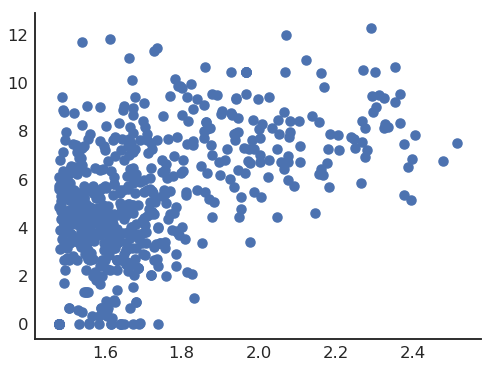

In [84]:
fig, ax = plot_style_utils.simple_ax(figsize=(8,6))
ax.scatter(bright_df_gfp.normalized_qfunc, maxmin[1])

<ErrorbarContainer object of 3 artists>

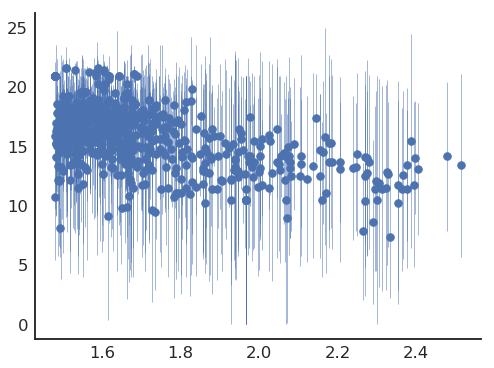

In [85]:
fig, ax = plot_style_utils.simple_ax(figsize=(8,6))

ax.errorbar(bright_df_gfp.normalized_qfunc,
            bright_df_gfp.d_from_active.map(np.mean), 
            bright_df_gfp.d_from_active.map(np.std), 
            linestyle='None',marker='.', linewidth=.5, markersize=15)

In [86]:
bright_df_gfp.d_from_active

19       [14.877874374389648, 14.468297958374025, 10.00...
36       [14.877874374389648, 15.586417198181152, 20.94...
38       [14.877874374389648, 15.586417198181152, 11.38...
48       [14.877874374389648, 10.93511199951172, 16.265...
52       [14.877874374389648, 18.307884216308594, 0.0, ...
57       [14.877874374389648, 0.0, 20.940820693969727, ...
60       [14.877874374389648, 19.59852409362793, 20.940...
61       [14.877874374389648, 20.419992446899414, 20.94...
68       [14.877874374389648, 10.73488712310791, 20.940...
95       [14.877874374389648, 11.387840270996096, 20.94...
106      [14.877874374389648, 16.919843673706055, 20.94...
107      [14.877874374389648, 16.919843673706055, 20.94...
110      [14.877874374389648, 13.537205696105955, 16.91...
123      [14.877874374389648, 14.18482780456543, 20.940...
218      [14.877874374389648, 14.18482780456543, 6.4381...
226      [14.877874374389648, 14.18482780456543, 16.919...
238      [14.877874374389648, 13.713299751281738, 15.58.

2.2845284359414148e-45


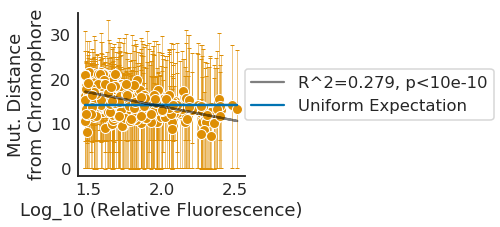

In [87]:
fig, ax = plot_style_utils.simple_ax(figsize=(3,3))
p10 = lambda x: np.percentile(x,.1)
p90 = lambda x: np.percentile(x,.9)
maxmin = np.array([bright_df_gfp.d_from_active.map(p10), bright_df_gfp.d_from_active.map(p90)])
maxmin = np.abs(maxmin - bright_df_gfp.d_from_active.map(np.mean).values.T)
x = bright_df_gfp.normalized_qfunc.values
y = bright_df_gfp.d_from_active.map(np.mean).values
ax.errorbar(x,
            y, 
            maxmin, 
            linestyle='None',marker='o', linewidth=.5, markersize=10,markeredgecolor='white', 
            capsize=2, color=palette[1], markeredgewidth=1, alpha=1)

slope, intercept, r_value, p_value, std_err = scistats.linregress(x, y)
print(p_value)
ax.plot(x, intercept + slope*x, color='black', alpha=.5, 
        label=f'R^2={np.around(r_value**2, 3)}, p<10e-10', zorder=10000)
ax.plot(x, [np.mean(gfp_struct.d_from_active)] * len(x),color=palette[0], alpha=1, 
        label=f'Uniform Expectation', zorder=1000) 
ax.legend(loc="center left", bbox_to_anchor=(.95, 0.5))
ax.set_xlabel('Log_10 (Relative Fluorescence)')
ax.set_ylabel('Mut. Distance\nfrom Chromophore')
plot_style_utils.save_for_pub(fig,'./gfp_distance_correlation.pdf')

In [88]:
r_value

-0.5283302635142426

In [89]:

num_bright_mutants / np.sum(num_bright_mutants)

array([0.02137998, 0.        , 0.01846453, 0.        , 0.02040816,
       0.        , 0.00777454, 0.00437318, 0.01506317, 0.03304179,
       0.        , 0.01263362, 0.01895044, 0.0447036 , 0.02040816,
       0.00826045, 0.00097182, 0.01895044, 0.        , 0.00485909,
       0.02040816, 0.        , 0.02137998, 0.01311953, 0.        ,
       0.00777454, 0.        , 0.        , 0.        , 0.00485909,
       0.00291545, 0.005345  , 0.00485909, 0.00340136, 0.0058309 ,
       0.07968902, 0.00048591, 0.        , 0.0170068 , 0.02623907,
       0.        , 0.00048591, 0.03012634, 0.01263362, 0.        ,
       0.        , 0.00728863, 0.00777454, 0.02380952, 0.01652089,
       0.05685131, 0.00242954, 0.        , 0.00631681, 0.01020408,
       0.        , 0.01068999, 0.0058309 , 0.00194363, 0.        ,
       0.00340136, 0.        , 0.00048591, 0.02478134, 0.        ,
       0.01506317, 0.        , 0.04081633, 0.01263362, 0.08163265,
       0.00437318, 0.0563654 , 0.00340136, 0.00048591, 0.     

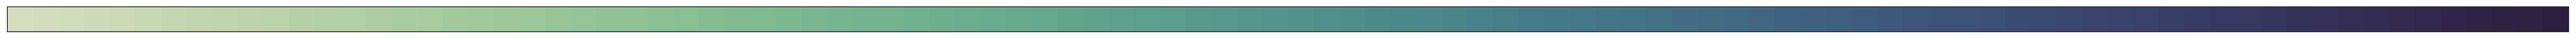

In [90]:
sns.palplot(plot_style_utils.SEQ_PALETTE)

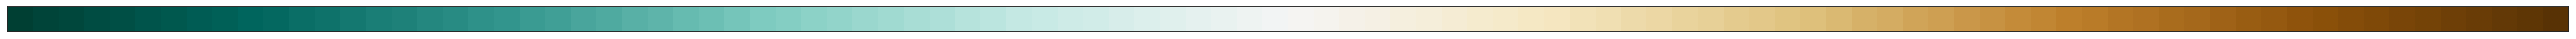

In [91]:
sns.palplot(plot_style_utils.DIV_PALETTE)

[[ 3.84483266 11.51292546  3.99136232 ...  5.54747918  5.14286974
   6.52404105]
 [ 3.84483266 11.51292546  3.99136232 ...  5.54747918  5.14286974
   6.52404105]
 [ 3.84483266 11.51292546  3.99136232 ...  5.54747918  5.14286974
   6.52404105]
 ...
 [ 3.84483266 11.51292546  3.99136232 ...  5.54747918  5.14286974
   6.52404105]
 [ 3.84483266 11.51292546  3.99136232 ...  5.54747918  5.14286974
   6.52404105]
 [ 3.84483266 11.51292546  3.99136232 ...  5.54747918  5.14286974
   6.52404105]]


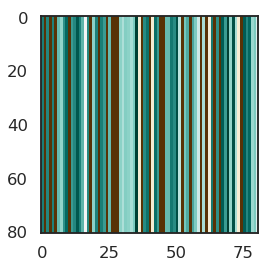

In [92]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(plot_style_utils.DIV_PALETTE)
data = np.concatenate([-np.log(num_bright_mutants / np.sum(num_bright_mutants) +.00001) for _ in range(len(num_bright_mutants))]).reshape(num_bright_mutants.shape[0],num_bright_mutants.shape[0] )
print(data)
plt.imshow(data, cmap=cmap)

In [93]:
import matplotlib.colors as colors

colors.to_hex(cmap(max(num_bright_mutants / np.sum(num_bright_mutants))))

'#016058'

In [94]:
to_color = num_bright_mutants / np.sum(num_bright_mutants)
to_color = to_color / np.max(to_color)

In [95]:
def prop_vals_to_idx(x):
    return np.round(255*(x - np.min(x))/(np.max(x) - np.min(x))).astype(int)
def prop_vals_to_rgb(x, cmap):
    return cmap(prop_vals_to_idx(x)).squeeze()[:,:3]
def rgb_to_hex(rgb):
    return ["0x{0:02x}{1:02x}{2:02x}".format(
        int(np.round(255*rgb[i,0])), 
        int(np.round(255*rgb[i,1])), 
        int(np.round(255*rgb[i,2]))) for i in range(rgb.shape[0])]
def prop_vals_to_hex(x, cmap):
    return rgb_to_hex(prop_vals_to_rgb(x, cmap))

In [96]:

cmap =cm.get_cmap(name='GnBu')
print(prop_vals_to_hex(to_color,cmap))

['0xc8eac3', '0xf7fcf0', '0xd0ecc9', '0xf7fcf0', '0xccebc5', '0xf7fcf0', '0xe6f5e0', '0xedf8e7', '0xd7efd1', '0x9ed9b8', '0xf7fcf0', '0xdcf1d6', '0xcfecc8', '0x69c2ca', '0xccebc5', '0xe4f5df', '0xf5fbee', '0xcfecc8', '0xf7fcf0', '0xecf8e6', '0xccebc5', '0xf7fcf0', '0xc8eac3', '0xdaf1d5', '0xf7fcf0', '0xe6f5e0', '0xf7fcf0', '0xf7fcf0', '0xf7fcf0', '0xecf8e6', '0xf1f9ea', '0xebf7e5', '0xecf8e6', '0xeff9e9', '0xeaf7e4', '0x084889', '0xf6fbef', '0xf7fcf0', '0xd3eecc', '0xb7e3bc', '0xf7fcf0', '0xf6fbef', '0xaadeb6', '0xdcf1d6', '0xf7fcf0', '0xf7fcf0', '0xe6f6e1', '0xe6f5e0', '0xc0e6c0', '0xd3eecd', '0x3a9cc7', '0xf1faeb', '0xf7fcf0', '0xe9f6e3', '0xe0f3db', '0xf7fcf0', '0xdff3da', '0xeaf7e4', '0xf3faec', '0xf7fcf0', '0xeff9e9', '0xf7fcf0', '0xf6fbef', '0xbde5be', '0xf7fcf0', '0xd7efd1', '0xf7fcf0', '0x7accc4', '0xdcf1d6', '0x084081', '0xedf8e7', '0x3c9fc8', '0xeff9e9', '0xf6fbef', '0xf7fcf0', '0x80cec2', '0xd0ecc9', '0xa7ddb5', '0xeef9e8', '0xeaf7e4', '0xf3fbed']


In [97]:
mutant_counts_df = pd.DataFrame({
    'res_index':30 + np.array(range(81)),
    'seq':list(WT_REGION),
    'ET':num_mutants,
    'bright':num_bright_mutants
})
mutant_counts_df

,res_index,seq,ET,bright
0,30,S,473,44
1,31,G,145,0
2,32,E,592,38
3,33,G,96,0
4,34,E,523,42
5,35,G,98,0
6,36,D,168,16
7,37,A,159,9
8,38,T,415,31
9,39,Y,892,68


In [98]:

mutant_counts_df = mutant_counts_df.set_index('res_index', drop=True)
mutant_counts_df

,seq,ET,bright
res_index,,,
30,S,473,44
31,G,145,0
32,E,592,38
33,G,96,0
34,E,523,42
35,G,98,0
36,D,168,16
37,A,159,9
38,T,415,31


In [99]:
mutant_counts_df.loc[[65,66,67],:]

,seq,ET,bright
res_index,,,
65,S,1660,164
66,Y,853,1
67,G,72,0


In [100]:
# Pymol collapses the chromophore (SYG) into single molecule at
# index 66. Add together counts from 65, 66, and 67, and set the
# The single chromophore molecule will have counts from all of these.
mutant_counts_df.loc[66,'ET'] = np.sum(
    mutant_counts_df.loc[[65,66,67],'ET'])
mutant_counts_df.loc[66,'bright'] = np.sum(
    mutant_counts_df.loc[[65,66,67],'bright'])
mutant_counts_df.loc[[65,67],['ET','bright']] = [[0,0],[0,0]]
mutant_counts_df.loc[66,'bright'] = np.sum(
    mutant_counts_df.loc[[65,66,67],'bright'])

In [101]:
# IMPT! pymol removes the chromophore but inserts 2 fake indices,
# one at the chromophore and one in position 67
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(mutant_counts_df)

          seq    ET  bright
res_index                  
30          S   473      44
31          G   145       0
32          E   592      38
33          G    96       0
34          E   523      42
35          G    98       0
36          D   168      16
37          A   159       9
38          T   415      31
39          Y   892      68
40          G    55       0
41          K   565      26
42          L   611      39
43          T   964      92
44          L   443      42
45          K   452      17
46          F   117       2
47          I   534      39
48          C     3       0
49          T   439      10
50          T   759      42
51          G   292       0
52          K   634      44
53          L   576      27
54          P    37       0
55          V   620      16
56          P    61       0
57          W    40       0
58          P    60       0
59          T   208      10
60          L   540       6
61          V   776      11
62          T   417      10
63          T   406 

In [102]:
to_color = mutant_counts_df['bright'] / np.sum(mutant_counts_df['bright'])
to_color = to_color / np.max(to_color)

In [103]:
cmap =cm.get_cmap(name='GnBu')
print(prop_vals_to_hex(to_color,cmap))

['0xc8eac3', '0xf7fcf0', '0xd0ecc9', '0xf7fcf0', '0xccebc5', '0xf7fcf0', '0xe6f5e0', '0xedf8e7', '0xd7efd1', '0x9ed9b8', '0xf7fcf0', '0xdcf1d6', '0xcfecc8', '0x69c2ca', '0xccebc5', '0xe4f5df', '0xf5fbee', '0xcfecc8', '0xf7fcf0', '0xecf8e6', '0xccebc5', '0xf7fcf0', '0xc8eac3', '0xdaf1d5', '0xf7fcf0', '0xe6f5e0', '0xf7fcf0', '0xf7fcf0', '0xf7fcf0', '0xecf8e6', '0xf1f9ea', '0xebf7e5', '0xecf8e6', '0xeff9e9', '0xeaf7e4', '0xf7fcf0', '0x084688', '0xf7fcf0', '0xd3eecc', '0xb7e3bc', '0xf7fcf0', '0xf6fbef', '0xaadeb6', '0xdcf1d6', '0xf7fcf0', '0xf7fcf0', '0xe6f6e1', '0xe6f5e0', '0xc0e6c0', '0xd3eecd', '0x3a9cc7', '0xf1faeb', '0xf7fcf0', '0xe9f6e3', '0xe0f3db', '0xf7fcf0', '0xdff3da', '0xeaf7e4', '0xf3faec', '0xf7fcf0', '0xeff9e9', '0xf7fcf0', '0xf6fbef', '0xbde5be', '0xf7fcf0', '0xd7efd1', '0xf7fcf0', '0x7accc4', '0xdcf1d6', '0x084081', '0xedf8e7', '0x3c9fc8', '0xeff9e9', '0xf6fbef', '0xf7fcf0', '0x80cec2', '0xd0ecc9', '0xa7ddb5', '0xeef9e8', '0xeaf7e4', '0xf3fbed']


In [104]:
print(bright_df_gfp[bright_df_gfp.seq.map(lambda s: s[65] != 'Y')].region.values[0][66])

R


In [105]:
bright_df_gfp.seq.iloc[0][65]

'Y'

In [106]:
freak = bright_df_gfp[bright_df_gfp.seq.map(lambda s: s[65] != 'Y')]

In [107]:
freak.to_csv('freak_GFG.csv')

In [108]:
freak.d_from_active.values[0]

[13.713299751281738,
 13.537205696105955,
 13.33405590057373,
 10.73488712310791,
 0.0,
 0.0,
 6.438129425048827,
 23.261232376098636,
 20.940820693969727,
 13.59048843383789]

In [109]:
freak['seq'].values[0][60:70]

'VTTLGFGVMC'

In [110]:
freak['seq'].values[0][64:67]

'GFG'

In [111]:
constants.AVGFP_AA_SEQ[64:67]

'SYG'

In [112]:
ticks = np.linspace(0, 
                               np.max(mutant_counts_df['bright'] / np.sum(mutant_counts_df['bright'])),
                               num=6
                              )
ticks = np.around(ticks,2)
ticks

array([0.  , 0.02, 0.03, 0.05, 0.07, 0.08])

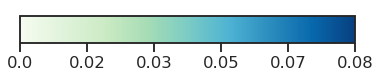

In [113]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=None,
                                orientation='horizontal')

cb1.ax.set_xticklabels(ticks)#cb1.set_label('Mutation frequency')
plot_style_utils.save_for_pub(fig,'./gfp_colorbar.pdf')

In [114]:
# exactly the same edits 